# BBC News Classification

In [1]:
from itertools import permutations
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import ComplementNB
import spacy
from wordcloud import WordCloud

%matplotlib inline
sns.set_style("dark")

Note: the tokenizer used in this notebook requires the spaCy "en_core_web_sm" model.  Uncomment the following code block if you would like to download the model.

In [2]:
## uncomment the following line to download the spacy model `en_core_web_sm`
# !python -m spacy download en_core_web_sm

In [3]:
# function to create and display word clouds
def plot_wordclouds(data, agg=False):
    if agg:
    # plot wordcloud aggregating across all documents
        cloud =  WordCloud(background_color="black", max_words=50
                           ).generate_from_frequencies(data.sum(axis=0))
        plt.figure(figsize=(8,4))
        plt.imshow(cloud)
        plt.axis("off")
        plt.title("all training documents (tf-idf)")
        plt.show()

    else:
    #plot a separate wordcloud for each nmf component
        for i in range(data.shape[0]):
            cloud =  WordCloud(background_color="black", max_words=50
                               ).generate_from_frequencies(data.loc[i,])
            plt.figure(figsize=(8,4))
            plt.imshow(cloud)
            plt.axis("off")
            plt.title(f"component {i} (tf-idf)")
            plt.show()

---
## EDA



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


<AxesSubplot:xlabel='Category', ylabel='Count'>

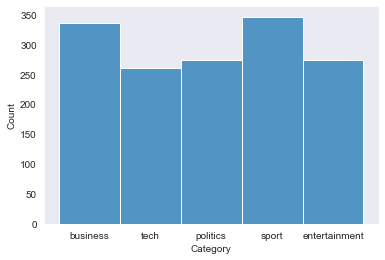

In [4]:
df_train = pd.read_csv("BBC News Train.csv")
df_train.info()
sns.histplot(data=df_train, x="Category", discrete=True)

There is no need for data cleaning since there are no missing or improperly formatted values in the dataset.

The labels are reasonably balanced, so there's no need to consider under/oversampling the training dataset.  I will use accuracy as the evaluation metric because that's what Kaggle will use to score submissions for this competition.  Accuracy is a valid evaluation metric since the labels are reasonably balanced.


### Plan of Analysis (Unsupervised):
1. Feature Extraction (*Tf-idf vectorization*)
2. Topic Extraction (*Non-negative Matrix Factorization*)
3. Label documents based on NMF components
4. Evaluate model and tune hyperparameters



---
## Feature Extraction

#### TF-IDF

Raw text must be converted to a matrix of features that represent the key words of each document.  There are many methods for converting raw text into a matrix form.  The method I will use is **"term frequency - inverse document frequency" (TF-IDF)**

TF-IDF represents the importance of a word within a document.  The TF-IDF value **increases** as a term appears more often within **a single document** (the "term-frequency" component) and **decreases** if that term appears in **many documents** (the "inverse document frequency" component).  This ensures that common, unimportant words like "the" or "to" have TF-IDF values close to zero despite appearing very frequently.

The "default" TF-IDF's formula scales the term-frequency component linearly with the number of times the word appears in a document.  Another variation of TF-IDF replaces the linear scaling with logarithmic scaling (sklearn's TfidfVectorizer calls this variation `sublinear_tf)`. The idea behind this variation is to reduce the importance placed on each *additional* occurrence of the term within a document (i.e., a term appearing 20 times in one document might *not* truly indicate double the importance as if it appeared 10 times)

#### Lemmatization

The simplest way of vectorizing raw text is to split the text into words and then count the resulting words; however, this method has the major flaw of considering different variations of a word to be entirely distinct -- e.g., "computer" and "computers" would be considered entirely different terms.

Lemmatization is the process of converting variations of a word into a single consistent form  -- e.g., "is", "am", and "are" should all be converted to "be" before calculating TF-IDF.  Sklearn's TfidfVectorizer doesn't automatically lemmatize words, but we can pass it a custom tokenizer built from a spaCy model with a built-in lemmatizer.

In [5]:
# create a "custom" lemmatizer to replace sklearn's default tokenizer
nlp=spacy.load("en_core_web_sm", exclude=["textcat", "ner", "parser"])
def lemmatizer(doc):
    text = nlp(doc)
    lem = []
    for t in text:
        if len(t) > 2:
            if not t.is_stop: #ignore stopwords like "to", "for", "as", etc.
                lem.append(t.lemma_)
    return lem

In [6]:
vectorizer = TfidfVectorizer(
    tokenizer= lemmatizer,
    max_df=.5, #terms that appear in more than half of the documents will be excluded
    sublinear_tf=True,
    min_df=2 # terms that appear in fewer than 2 documents will be excluded
)
X_train = pd.DataFrame(data=vectorizer.fit_transform(df_train["Text"]).toarray(),
                       columns=vectorizer.get_feature_names_out())
print(X_train.shape)

(1490, 10958)


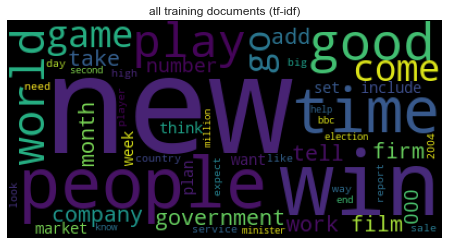

In [7]:
# wordcloud of the 50 most frequent (TF-IDF) words among the training set's documents
plot_wordclouds(X_train, agg=True)

This training set wordcloud shows that our vectorization was successful. We could probably squeeze better performance out of our model if we spent more time fine-tuning the list of stopwords since some of the top-50 terms ("go", "come", "like", "000", etc.) may not be good predictors of a document's category. In the future, we might try adding them to the list of stopwords.

---
## Unsupervised Model Building/Training

The NMF will ignore any terms that it didn't encounter when it was fit, so **we should combine the test and train datasets** to ensure that our model incorporates *all* terms from the testing dataset. Because this model is unsupervised, we can combine the testing and training datasets without risk of overfitting our model.



In [8]:
#Combine test and train datasets for the reason mentioned above.
df_test = pd.read_csv("BBC News Test.csv")
df_all = pd.concat([df_train, df_test], axis=0)
df_all.info()
# create document-term matrix for the combined test+train dataset
X_all = pd.DataFrame(data=vectorizer.fit_transform(df_all["Text"]).toarray(),
                       columns=vectorizer.get_feature_names_out())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2225 entries, 0 to 734
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  2225 non-null   int64 
 1   Text       2225 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 69.5+ KB


#### NMF hyperparameters

For this NMF, we will set `n_components=5` because we know that there are 5 categories in the dataset.  The `beta_loss` parameter has 2 reasonable choices (`frobenius` and `kullback-liebler`).  We'll try each of the `beta_loss` options later on in this notebook when tuning hyperparameters.


In [9]:
nmf = NMF(n_components=5,
          init="nndsvda",
          beta_loss="kullback-leibler",
          solver="mu",
          random_state=1)

W_all = nmf.fit_transform(X_all)
H_all = pd.DataFrame(data=nmf.components_, columns=vectorizer.get_feature_names_out())
H_all.shape

(5, 13734)

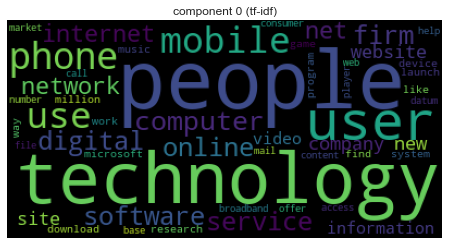

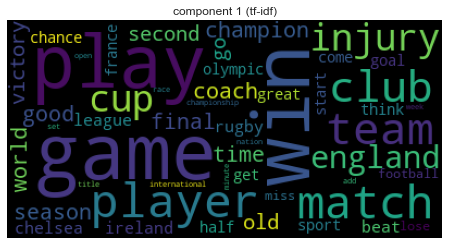

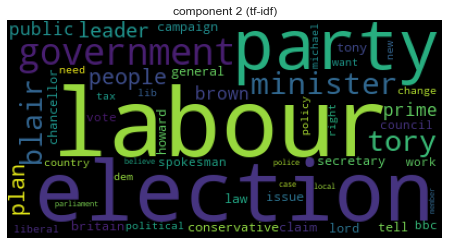

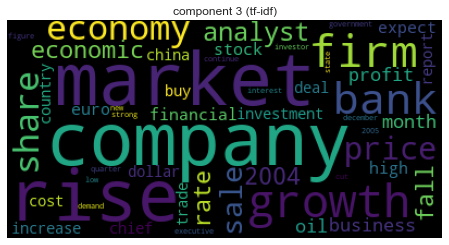

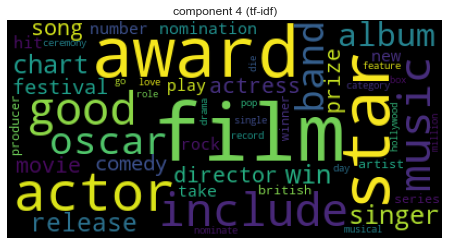

In [10]:
#plot one wordcloud for each of the 5 NMF components
plot_wordclouds(H_all, agg=False)

In [11]:
# dictionary for converting components to topics.
#   determined by visual inspection of word clouds
topic_dict = {0:"tech",
              1:"sport",
              2:"politics",
              3:"business",
              4:"entertainment"}

# label documents based on largest component
W_all = pd.DataFrame(data=W_all)
# Label each document based on its largest component
W_all["Category"] = W_all.apply(lambda doc: topic_dict[np.argmax(doc)],axis=1)
W_all.head()

,0,1,2,3,4,Category
0,2.649413e-02,4.503164e-14,1.068487e-07,7.660542e-02,2.196833e-03,business
1,1.364606e-17,1.767424e-29,1.201375e-19,1.190431e-01,1.100571e-35,business
2,2.124753e-03,7.019510e-16,5.011517e-02,7.060849e-02,1.606923e-16,business
3,1.313375e-01,5.918154e-25,6.304197e-21,1.277773e-19,4.691123e-16,tech
4,2.184714e-02,5.875320e-06,9.148413e-10,9.623649e-02,5.292688e-15,business


In [12]:
# calculate accuracy on the training set
y_true_train = df_all.iloc[0:1490,2]
y_pred_train = W_all.iloc[0:1490,-1]
print(f"Unsupervised Model (NMF) \n training accuracy= {accuracy_score(y_true_train, y_pred_train)}")

Unsupervised Model (NMF) 
 training accuracy= 0.9590604026845637


The training accuracy is quite good! But before we submit our test set predictions to Kaggle, we should try other combinations of hyperparameters.

Note: for the sake of readability, the code blocks for hyperparameter tuning do not appear in this notebook.  Instead, a table of parameters and training accuracy is provided.

#### <center> NMF Hyperparameter tuning results</center>
| **tokenizer**      | **sublinear_tf** | **beta_loss**    | **training accuracy** |
|--------------------|------------------|------------------|-----------------------|
| lemmatizer (spaCy) | False            | frobenius        | 0.9275                |
| lemmatizer (spaCy) | False            | kullback-leibler | 0.9510                |
| lemmatizer (spaCy) | True             | frobenius        | 0.9517                |
| lemmatizer (spaCy) | True             | kullback-leibler | 0.9597                |
| default (sklearn)  | False            | frobenius        | 0.9100                |
| default (sklearn)  | False            | kullback-leibler | 0.9490                |
| default (sklearn)  | True             | frobenius        | 0.9463                |
| default (sklearn)  | True             | kullback-leibler | **0.9624**            |


# Unsupervised model's kaggle score = 0.96326

After rerunning the model with the best set of hyperparameters: `TfidfVectorizer(tokenizer=None, sublinear_tf=False)` and `NMF(beta_loss="kullback-leibler")` I submitted the results to Kaggle, and scored 0.96326

---
## Supervised Learning Model

For my supervised model, I will use a Complement Naive Bayes (CNB) classifier.

A Naive Bayes classifier seems well-suited for this problem because their runtimes are very fast, and they are known to perform well on text-classification problems without requiring hyperparameter tuning.  I specifically chose the ComplementNB classifier because the sklearn documentation indicated that CNBs often outperform other NB classifiers at text classification tasks.

In [13]:
# testing revealed that the CNB and NMF based models performed better with different vectorizer parameters
vectorizer_cnb = TfidfVectorizer(
    tokenizer= lemmatizer,
    sublinear_tf=False,
    max_df=.5,
    min_df=2
)
# Vectorize the training data with parameters that were most effective for the CNB model
X_train_cnb = pd.DataFrame(data=vectorizer_cnb.fit_transform(df_train["Text"]).toarray(),
                           columns=vectorizer_cnb.get_feature_names_out())

cnb = ComplementNB().fit(X=X_train_cnb, y=df_train["Category"])
cnb_scores = cross_val_score(estimator=cnb, X=X_train_cnb, y=df_train["Category"],
                             scoring="accuracy", cv=5, n_jobs=-1)
print(f"5-fold cv accuracy {np.mean(cnb_scores)}")

5-fold cv accuracy 0.9711409395973154


The cross-validation accuracy is higher than our Unsupervised model's training accuracy, so it looks like it's ready to submit to Kaggle for scoring.

In [14]:
# # predict on test set, format predictions to match Kaggle's requirements, and save to "submission.csv"

# df_submission_cnb = pd.DataFrame(df_test["ArticleId"])
# X_test_cnb = pd.DataFrame(data=vectorizer_cnb.transform(df_test["Text"]).toarray(),
#                       columns=vectorizer_cnb.get_feature_names_out())
# df_submission_cnb["Category"] = cnb.predict(X_test_cnb)
# df_submission_cnb.head()
# df_submission_cnb.to_csv("submission.csv", index=False)

# Final Kaggle scores
   * CNB score: **0.97687**
   * NMF score: **0.96326**

# Supervised vs. Unsupervised Learning

In this scenario, the supervised model (CNB) outperformed the unsupervised model (NMF) in all aspects.  The NMF had a substantially longer run-time than the CNB, and the CNB's predictions were more accurate.

For one last comparison, I'll compare the performance of the two models with different sizes of training sets.  The CNB will be evaluated with 5-fold cross validation and the NMF will be evaluated by training accuracy.  To simplify the calculations, both models will use data transformed by the same vectorizer. I will use vectorizer parameters that worked well for both models (but weren't optimal for either model)

In [15]:
# function that returns the accuracy of the "best match" between NMF component label and News Category labels
def label_permute_compare(ytdf, yp, n=5):
    perms = list(permutations(range(n)))
    categories = set(ytdf["Category"].values)
    best_match = (None, 0.0)

    for p in perms:
        yt_relabeled = ytdf["Category"].replace(categories, p)
        acc = accuracy_score(yt_relabeled, yp)
        if acc > best_match[1]:
            best_match = (p, acc)
    return best_match[1]


In [16]:
# Compare performance of NMF vs CNB models for different sample sizes and plot the results
df_comparison = pd.DataFrame({"size":np.arange(.1, 1.1, step=.1),
                              "CNB accuracy":np.zeros(10),
                              "NMF accuracy":np.zeros(10)})

for i, sample_size in enumerate(df_comparison["size"]):
    df_sample = df_train.sample(frac=sample_size, random_state=1)
    df_sample.head()
    X_sample = pd.DataFrame(data=vectorizer.fit_transform(df_sample["Text"]).toarray(),
                            columns=vectorizer.get_feature_names_out())
    # NMF
    nmf_sample = NMF(n_components=5,
              init="nndsvda",
              beta_loss="kullback-leibler",
              solver="mu",
              random_state=1)
    W_sample = pd.DataFrame(data=nmf_sample.fit_transform(X_sample))
    # label documents based on largest component
    W_sample["Category"] = W_sample.apply(lambda doc: np.argmax(doc),axis=1)
    df_comparison.iloc[i,2] = label_permute_compare(df_sample, W_sample["Category"])

    # CNB
    cnb_sample = ComplementNB()
    cnb_scores = cross_val_score(estimator=cnb_sample,
                                 X=X_sample,
                                 y=df_sample["Category"],
                                 scoring="accuracy", cv= 5, n_jobs=-1)
    df_comparison.iloc[i,1] = np.mean(cnb_scores)

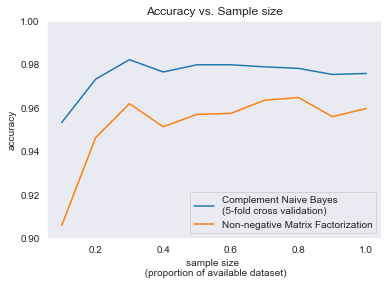

In [17]:
plt.plot("size", "CNB accuracy", data= df_comparison,
         label="Complement Naive Bayes \n(5-fold cross validation)")
plt.plot("size", "NMF accuracy", data= df_comparison,
         label="Non-negative Matrix Factorization")
plt.ylabel("accuracy")
plt.xlabel("sample size \n (proportion of available dataset)")
plt.ylim(0.9,1.0)
plt.title("Accuracy vs. Sample size")
plt.legend()
plt.show()



The lineplot shows that at all train data sizes, the CNB model outperformed the NMF.  Also, there is no evidence of overfitting for either model, since both models had higher test accuracy than train accuracy.


#### Supervised vs. Unsupervised Learning: Conclusion

Overall, the CNB outperformed the NMF in every possible way except that it is reliant upon labeled data.  The CNB was faster and more accurate, and that advantage held for all training data sizes.


## References:

https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction

https://scikit-learn.org/stable/modules/naive_bayes.html#complement-naive-bayes

https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html

https://spacy.io/api/lemmatizer